In [2]:
import os
import itertools
import zipfile
import numpy as np
import pandas as pd
# Не сворачивать колонки в датафрейме
pd.options.display.max_columns = 50
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import scipy
# Рисует 3d точки в 2мерном пространстве
from auxiliary_functions.draw3d import *;
import warnings
warnings.filterwarnings('ignore')

from config import FILE_PATH;

In [5]:
from sklearn.decomposition import PCA
# Пакет для отрисовки разделяющей границы
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

### Снижение размерности

Очень часто в анализе данных встречается ситуация, когда объект описан большим числом признаков, но при этом, в этом большимерном пространтсве объекты лежат в какой-то маломерном подпространстве (картинка ниже). Тогда объекты можно описать меньшим числом признаков, главная задача - как выбрать эти признаки и какое должно быть их число, чтобы описание объектов "не сильно пострадало".

На картинке ниже каждый объекты $x_{1}, \dots, x_{n}$ описываются 3 координатами, однако все объекты лежат на плоскости $L = span\{\vec a_{1}, \vec a_{2} \}$ : (p, q, 3p-5q), поэтому для описания этих объектов достаточно знать 2 значения: p и q. С точки зрения линейной алгебры это означает, что мы можем описать наши объекты через базис плоскости L, то есть $x_{i} = \alpha_{1} \cdot \vec a_{1} + \alpha_{2} \cdot \vec a_{2}$ и тогда координатами объекта $x_{i}$ в базисе плоскости L можно назвать $x_{i, L} = (\alpha_{1}, \alpha_{2})$

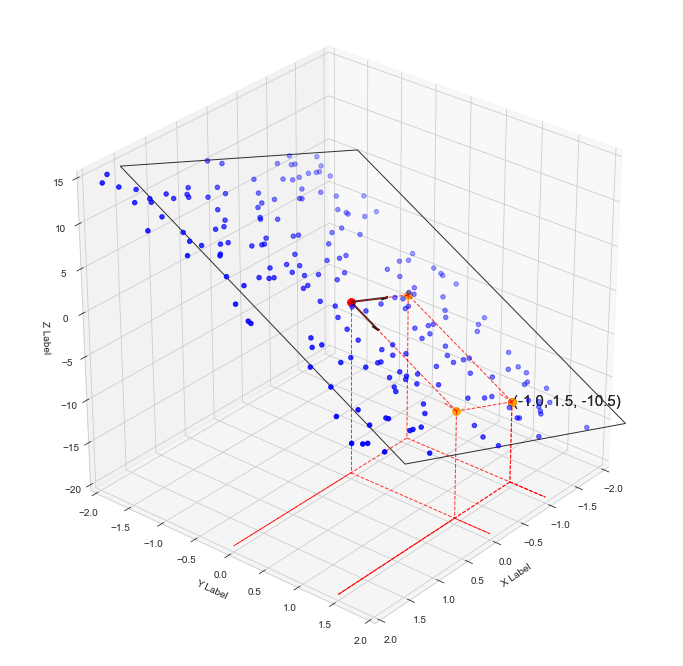

In [6]:
draw_final_plot()

В примере выше исходная точка $x = (-1, 1.5, -10.5)$. Если в качестве базиса плоскости принять вектора $a_{1} = (0, 1, -5), \ a_{2} = (-1, 0, -3)$, то координаты вектора $x$ в базисе этой плоскости принимают вид $x_{a} = (1.5, 1)$, так, как $ \ \begin{pmatrix}-1 \\ 1.5 \\-10.5 \end{pmatrix} = 1.5 \cdot \begin{pmatrix} 0 \\ 1 \\-5 \end{pmatrix} + 1 \cdot \begin{pmatrix}-1 \\ 0 \\-3 \end{pmatrix}$

__Формальная постановка задачи PCA:__

Хотим найти такое линейное подпространство $\mathcal{L}_{A}$ в $\mathbb{R}^{D}$, размерности $\dim(\mathcal{L}_{A}) = d << D$, описываемое матрицей $A = \begin{bmatrix} | & \dots & |\\ a_{1} & \dots & a_{d}\\ | & \dots & | \end{bmatrix}, \ a_{j} \in \mathbb{R}^{D}$ - базисные вектора $\mathcal{L}_{A}$, такое, что оно "наилучшим образом" описывает наши объекты. Это означает, что сумма расстояний от исходных объектов до данного подпространства минимальна. Запишем это формально:

$$
(\Delta) \ \sum\limits_{i=1}^n \| x_{i} - x^p_{i} \|^2 \to \min\limits_{a_{1}, \dots, a_{d}} \ 
$$ где $x_{i}^p$ - проекция объекта $x_{i}$ на подпространство $\mathcal{L}_{A}$

Найдём, как выражается $x_{i}^p$ через матрицу А и объект $x_{i}$, для этого составим задачу поиска проекции на $\mathcal{L}_{A}$:

$$
(\ast) \ \left \{
\begin{array}{rcl}
\frac{1}{2} \| x - x_{i} \|^2 \to \min\limits_{x} \ &\text{(хотим минимизировать расстояние)}\\ 
\exists \alpha \in \mathbb{R}^d: \ x = A\alpha \ &\text{(но чтобы искомая точка (х) осталась в $\mathcal{L}_{A}$)} 
\end{array}
\right .
$$

__Комментарий:__

Если $x \in \mathcal{L}_{A}$, то $x$ выражается через базис $\mathcal{L}_{A}$ (то есть через $a_{j}, \ j=1, \dots, d$). Имеем: $\exists \alpha_{1}, \dots, \alpha_{d} \in \mathbb{R}: \ \vec x = \alpha_{1} \cdot \vec a_{1} + \alpha_{2} \cdot \vec a_{2} + \dots + \alpha_{d} \cdot \vec a_{d}$ - это можно переписать в матричном виде: $\underset{D \times d}{\begin{bmatrix} | & \dots & |\\ a_{1} & \dots & a_{d}\\ | & \dots & | \end{bmatrix}} \cdot \underset{d \times 1}{\begin{bmatrix} \alpha_{1} \\ \vdots \\ \alpha_{d} \end{bmatrix}} = \underset{D \times 1}{\begin{bmatrix} x_{1} \\ \vdots \\ x_{D} \end{bmatrix}}$

Итак, с учётом комментария задача $(\ast)$ перепишется в виде:

$$
\frac{1}{2} \| x - A\alpha \|^2 \to \min\limits_{\alpha}
$$

Найдём оптимальные $\alpha$:

$
\nabla_{\alpha} \frac{1}{2} \| x - A\alpha \|^2 = \nabla_{\alpha} \frac{1}{2} \left( x - A\alpha \right)^T \left(  x - A\alpha \right) = \nabla_{\alpha} \frac{1}{2} \left( x^Tx - 2x^TA\alpha + \alpha^TA^TA\alpha  \right) = -2A^Tx + 2A^TA\alpha = 0
$

Получаем: $\boxed{\alpha^{\ast} = (A^TA)^{-1}A^Tx}$

__Комментарий:__

Вспомним, что базис в $\mathcal{L}_{A}$ может быть не произвольный, а какой-нибудь "хороший", в частности - мы можем выбрать в $\mathcal{L}_{A}$ ортонормированный базис ([процесс ортогонализации Грама-Шмидта](https://en.wikipedia.org/wiki/Gram–Schmidt_process)).

Тогда, если $a_{j} \perp a_{k}, \forall k \not = j$ и $\| a_{j} \| = 1 \ \forall j = 1, \dots, d$, то

$
A^TA = \underset{d \times D}{\begin{bmatrix} - & a_{1} & - \\ \vdots & \vdots & \vdots \\ - & a_{d} & - \end{bmatrix}} \cdot \underset{D \times d}{\begin{bmatrix} | & \dots & |\\ a_{1} & \dots & a_{d}\\ | & \dots & | \end{bmatrix}} = 
\begin{bmatrix} 
\langle a_{1}, a_{1} \rangle & \langle a_{1}, a_{2} \rangle & \dots & \langle a_{1}, a_{d} \rangle \\
\langle a_{2}, a_{1} \rangle & \langle a_{2}, a_{2} \rangle & \dots & \langle a_{2}, a_{d} \rangle  \\
\vdots & \vdots & \ddots & \vdots \\
\langle a_{d}, a_{1} \rangle & \langle a_{d}, a_{2} \rangle & \dots & \langle a_{d}, a_{d} \rangle \\
\end{bmatrix} = 
\begin{bmatrix}
1 & 0 & \dots & 0\\
0 & 1 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 1\\
\end{bmatrix} = I_{d}
$

С учётом комментария выше, получаем: $\boxed{\alpha^{\ast} = A^Tx}$ и $\boxed{x^p_{i} = A\alpha = AA^Tx}, \ $  ($\alpha \in \mathbb{R}^{d}, \ x_{i}^p \in \mathbb{R}^D$)

$\left. \right.$
$\left. \right.$
$\left. \right.$
$\left. \right.$

Вернёмся к нашей исходной задаче $(\Delta)$:

$
\sum\limits_{i=1}^n \| x_{i} - x_{i}^p \|^2 = \sum\limits_{i=1}^n \| x_{i} - AA^Tx_{i} \|^2 = \sum\limits_{i=1}^n \left( x_{i}^T - x_{i}^TAA^T \right) \left( x_{i} - AA^Tx_{i} \right) = \sum\limits_{i=1}^n x_{i}^T \underbrace{(I_{D} - AA^T)(I_{D} - AA^T)}_{I_{D} - AA^T} x_{i} = \sum\limits_{i=1}^n x_{i}^Tx_{i} - \sum\limits_{i=1}^n \underbrace{x_{i}^TAA^Tx_{i}}_{\| A^Tx_{i} \|^2} \to \min\limits_{a_{1}, \dots, a_{d}}
$

В последнем выражении в первом члене нет оптимизируемых параметров, значит от него можно избавиться. Рассмотрим второй член (избавимся от минуса и будем максимизировать выражение, вместо минимизации):

$
(o) \ \sum\limits_{i=1}^n x_{i}^TAA^Tx_{i} =  \sum\limits_{i=1}^n \| A^Tx_{i} \|^2 \to \max\limits_{a_{1}, \dots, a_{d}}
$

Рассмотрим отдельно $A^Tx_{i}$:

$
A^Tx = 
\underset{d \times D}{\begin{bmatrix} - & a_{1} & - \\ \vdots & \vdots & \vdots \\ - & a_{d} & - \end{bmatrix}} \cdot 
\underset{D \times 1}{\begin{bmatrix}
x_{1} \\ 
\vdots \\ 
x_{D} 
\end{bmatrix}} = 
\begin{bmatrix}
\langle a_{1}, x \rangle \\
\langle a_{2}, x \rangle \\
\vdots \\
\langle a_{d}, x \rangle \\
\end{bmatrix}
$

Вспомним, что $\forall b \in \mathbb{R}^k \ \| b \|^2 = b_{1}^2 + b_{2}^2 + \dots + b_{k}^2$

Тогда: $\| A^Tx_{i} \|^2 = \langle a_{1}, x_{i} \rangle^2 + \langle a_{2}, x_{i} \rangle^2 + \dots + \langle a_{d}, x_{i} \rangle^2 = \sum\limits_{k=1}^d \langle a_{k}, x_{i} \rangle^2$

Вернёмся к $(o)$:

$
\sum\limits_{i=1}^n \| A^Tx_{i} \|^2 = \sum\limits_{i=1}^n \sum\limits_{k=1}^d \langle a_{k}, x_{i} \rangle^2 =
\sum\limits_{i=1}^n \sum\limits_{k=1}^d \left( a_{k}^Tx_{i} \right)^2 = \left\{ \left( a_{k}^Tx_{i} \right)^2 = a_{k}^Tx_{i} \cdot a_{k}^Tx_{i} = a_{k}^Tx_{i} \cdot x_{i}^T a_{k} = a_{k}^T \left(x_{i} x_{i}^T\right) a_{k}   \right\} = \sum\limits_{i=1}^n \sum\limits_{k=1}^d a_{k}^T \left(x_{i} x_{i}^T\right) a_{k} = \sum\limits_{k=1}^d a_{k}^T \left( \underbrace{\sum\limits_{i=1}^n x_{i} x_{i}^T}_{S}  \right) a_{k}
$

__Замечание:__

Если домножить S на $\frac{1}{n}$, то $\frac{1}{n}\sum\limits_{i=1}^n x_{i} x_{i}^T$ это будет выборочная ковариационная матрица наших данных. (её также можно посчитать как: $S = \frac{1}{n}\sum\limits_{i=1}^n x_{i} x_{i}^T = \frac{1}{n}X^TX$)

Итак, мы пришли к тому, что 

$$
\sum\limits_{i=1}^n \| x_{i} - x^p_{i} \|^2 \to \min\limits_{a_{1}, \dots, a_{d}} \sim \sum\limits_{k=1}^d a_{k}^T S a_{k} \to \max\limits_{a_{1}, \dots, a_{d}}
$$

Однако, нужно не забыть, что по пути мы использовали тот факт, что в подпрастранстве $\mathcal{L}_{A}$ базис не произвольный, а ортонормированный ($\langle a_{j}, a_{k} \rangle = 0 \ \forall k \not = j, \ \| a_{j} \| = 1 \ \forall j=1, \dots, d $) - это надо учесть в оптимизационной задаче:

$$
\left \{
\begin{array}{rcl}
\sum\limits_{k=1}^d a_{k}^T S a_{k}& \to \max\limits_{a_{1}, \dots, a_{d}}\\
\langle a_{j}, a_{k} \rangle = 0& \ \forall k \not = j\\
\| a_{k} \|^2 = 1& \ \forall k=1, \dots, d
\end{array}
\right.
$$

Оказывается, условие на ортогональность можно не учитывать (это мы увидим позже). Давайте составим лагранжиан без него. Кроме того, заметим, что в наш функционал оптимизируемые параметры ($a_{k}$) входят как отдельные слагаемые, а значит, можно оптимизировать по $a_{k}$ отдельно:

$
L = a_{k}^TSa_{k} + \mu_{k} \cdot (a_{k}^Ta_{k} - 1)
$

$
\nabla_{a_{k}} L = 2Sa_{k} + 2\mu_{k}a_{k} = 0 \Rightarrow \boxed{Sa_{k} = \underbrace{-\mu_{k}}_{\gamma_{k}}a_{k}}
$

Решением последнего уравнения будет собственный вектор ($a_{k}$) для оператора S и соответствующее ему собственное значение $(\gamma_{k})$. Вопрос: какой же собственный вектор выбрать? Для этого подставим решение в исходный функционал:

$
a_{1}^T\underbrace{Sa_{1}}_{\gamma_{1}a_{1}} = \gamma_{1}\underbrace{a_{1}^Ta_{1}}_{\| a_{1} \| = 1} = \gamma_{1} \to\max
$

Получается, логично брать собственный вектор, соответствующий наибольшему собственному значению. То есть если нам нужно найти d векторов ($a_{1}, \dots, a_{d}$), то нам нужно:
<li> Найти собственные вектора и собственные значения у оператора S 
<li> Отсортировать собственные значения по невозрастанию
<li> Выбрать топ-d собственных векторов, соответствующих d наибольшим собственным значениям
$\left. \right.$
    
Само маломерное представление объекта $x \in \mathbb{R}^D$ это координаты его проекции ($x^{p}$) на $\mathcal{L}_{A}$, в базисе $\mathcal{L}_{A}$. То есть $\vec x^p = \alpha_{1} \cdot \vec a_{1} + \dots + \alpha_{d} \cdot \vec a_{d}, \quad \alpha = (\alpha_{1}, \dots, \alpha_{d})$ - и есть это маломерное представление. Напомним, что $\boxed{\alpha = A^Tx}$
$\left. \right.$    
$\left. \right.$    
$\left. \right.$    


__Комментарий:__ Покажем, почему условие на ортогональность векторов мы не учли в лагранжиане.
    
*Теорема:* У симметричного линейного оператора всегда существует базис из собственных векторов, и собственные вектора, соответствующие различным собственным значениям - ортогональны. 
    
Иными словами, эта теорема говорит о том, что раз у нас оператов S - симметричных, то $a_{k}$ будут ортогональны друг другу и это можно не учитывать в лагранже (если у нас есть одинаковые собственные значения, то в рамках них собственные вектора можно сделать ортогональными с помощью процесса Грама-Шмидта).

---

Алгоритм, позволяющий найти это малоразмерное (линейное) описание называется [Метод главных компонент](https://ru.wikipedia.org/wiki/Метод_главных_компонент) (PCA):

${\bf Алгоритм:}$

1) Центрируем данные $\left( x_{i}' = \frac{x_{i} - mean(x)}{\sigma(x)} \right)  \Rightarrow X_{st} = \begin{bmatrix} | & \dots & | \\ x_{1}' & \dots & x_{d}' \\ | & \dots & | \end{bmatrix}   $ .

2) Находим выборочную ковариационную матрицу $M = \frac{1}{n}X_{st}^TX_{st}$.

3) Находим её собственные векторы, отвечающие k самым большим по модулю собственным значениям.

Собственные векторы, найденные в пункте 3 это и будут главные компоненты, которые мы ищем.

Рассмотрим PCA на данных c картинки выше

In [332]:
X = np.c_[x, y, 2*x - 3*y]
X_st = (X - X.mean(axis=0))/X.std(axis=0)
M = (1/X_st.shape[0])*X_st.T.dot(X_st)
eigvals, eigvecs = np.linalg.eig(M)
eigvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
eigvals = np.sort(eigvals)[::-1]

Вектор собственных значений главных компонент

In [337]:
eigvals

array([1.98444539, 1.01555461, 0.        ])

Матрица из главных компонент

In [336]:
eigvecs

array([[-0.7043156 , -0.00646535,  0.70985755],
       [-0.58740338, -0.55619294, -0.58788322],
       [ 0.39861863, -0.83102805,  0.38793759]])

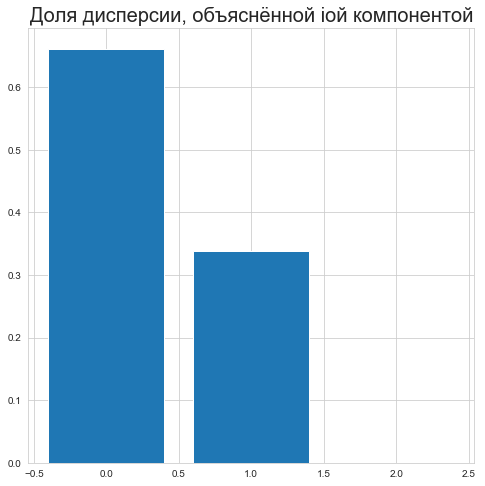

In [338]:
plt.bar(np.arange(3), eigvals/eigvals.sum());
plt.title('Доля дисперсии, объяснённой iой компонентой', fontsize=20);

Видим, что уже 2 главные компоненты описывают 100% дисперсии исходной выборки, а значит третий признак излишен.

Полученные главные компоненты всегда ортогональны друг другу (скалярное произведение равно 0). Ввиду этого свойства PCA так же применяют не только для снижения размерности, но и так же для [декорреляции признаков](https://en.wikipedia.org/wiki/Whitening_transformation).

Координаты главной компоненты означают, с какими весами исходные признаки входят в эту главную компоненту. Например comp1 = [-0.71,  -0.59, 0.39] означает, что $comp1 = -0.71 \cdot x - 0.59 \cdot y + 0.39 \cdot z$

При этом встаёт вопрос, как будут описываться иходные объекты через полученные главные компоненты. 

Обозначим исходные (стандартизованные) объекты за $x^{st}_{1}, \dots, x^{st}_{n} \quad x^{st}_{i} \in \mathbb{R}^d$. Обозначим главные компоненты за $u_{1}, \dots, u_{k} \quad u_{j} \in \mathbb{R}^d$ и матрицу из главных компонент за $U = \begin{bmatrix} | & \dots & |\\ u_{1} & \dots & u_{k} \\ | & \dots & | \end{bmatrix}, \ U \in \mathbb{R}^{d \times k}$. Тогда найти координаты исходного объекта $x^{st}_{i}$ в пространстве главных компонент можно по формуле: $x_{i}^{pc} = U^T \cdot x^{st}_{i}, $ где $x_{i}^{pc} \in \mathbb{R}^k$. Чтобы найти координаты всех объектов $X^{st} = \begin{bmatrix} - & x^{st}_{1} & - \\ \vdots & \vdots & \vdots \\ - & x^{st}_{n} & - \end{bmatrix}$ нужно перемножить $X^{st} \cdot U$

In [352]:
X_pc = X_st.dot(eigvecs[:, :2])
X_pc.shape

(200, 2)

Посмотрим на положение конкретного объекта в исходном и в новом пространствах

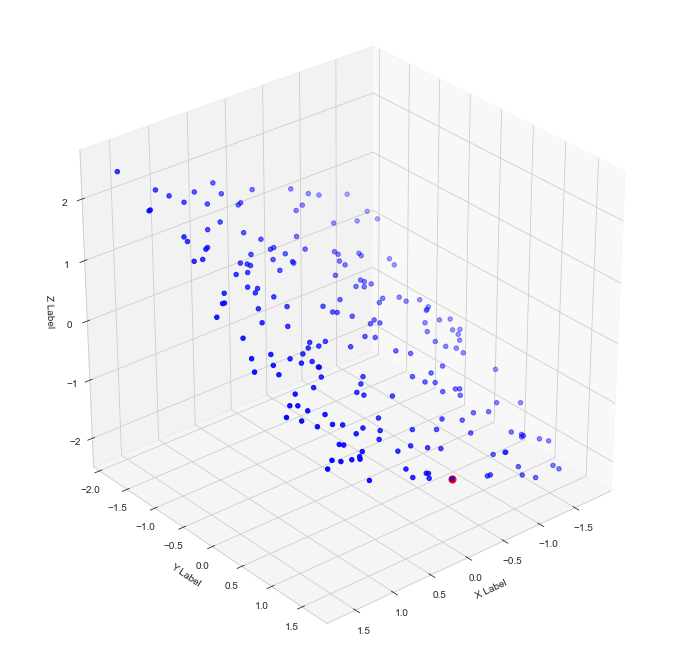

In [356]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_st[:, 0], X_st[:, 1], X_st[:, 2], color='blue')
ax.scatter(X_st[0, 0], X_st[0, 1], X_st[0, 2], color='red', s=50)
ax.view_init(30, 50)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label');

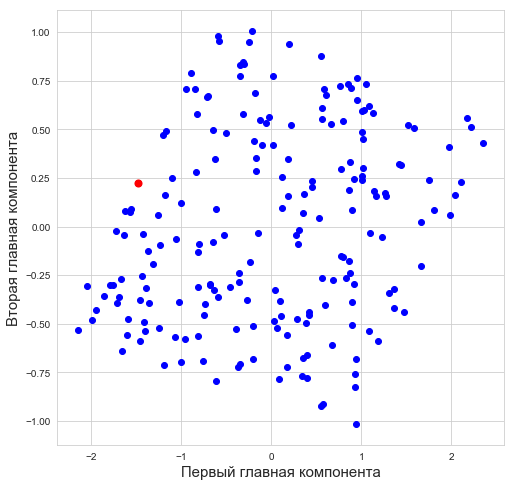

In [403]:
plt.scatter(X_pc[:, 0], X_pc[:, 1], color='blue')
plt.scatter(X_pc[0, 0], X_pc[0, 1], color='red', s=50);
plt.xlabel('Первый главная компонента', fontsize=15);
plt.ylabel('Вторая главная компонента', fontsize=15);

C использование sklearn

In [367]:
from sklearn.decomposition import PCA

In [397]:
pc = PCA(n_components=2).fit(X_st)
X_pc1 = pc.transform(X_st)

В данном случае матрица pc.components_ = $U^T$

In [400]:
pc.components_.T

array([[ 0.38793759, -0.83102805],
       [-0.58788322, -0.55619294],
       [ 0.70985755, -0.00646535]])

Полученное подпространство совпадает с найденным выше (хотя сама проекция отличается)

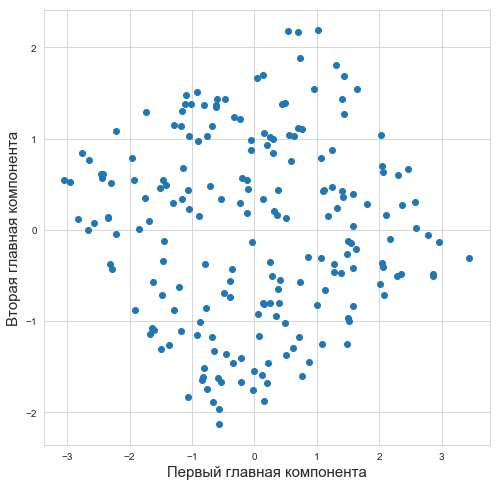

In [405]:
plt.scatter(X_pc1[:, 0], X_pc1[:, 1]);
plt.xlabel('Первый главная компонента', fontsize=15);
plt.ylabel('Вторая главная компонента', fontsize=15);

Для визуализации главных компонент полезно пользоваться диаграммой Хинтона - [Hinton Diagram](https://matplotlib.org/3.1.0/gallery/specialty_plots/hinton_demo.html) (когда много признаков лучше использовать sns.heatmap).

In [326]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    ax.set_xlabel('Компоненты', fontsize=15);
    ax.set_ylabel('Признаки', fontsize=15);
    ax.autoscale_view()
    ax.invert_yaxis()

### Применение PCA на реальных данных

Очень часто главные компоненты имеют довольно понятную интерпретацию, рассмотрим пример.

In [74]:
# Загрузка данных из .zip папки
with zipfile.ZipFile(os.path.join(FILE_PATH, 'data.zip')) as z:
    for filename in z.namelist():
        if not os.path.isdir(filename):
            with z.open(filename) as f:
                if 'us_presidents.csv' in f.name:
                    presidents_df = pd.read_csv(f)

Рассмотрим набор данных us\_presidents.csv, содержащий данные опроса 157 респондентов о том, какими качествами обладали президенты США. Респондентов просили отранжировать президентов по каждому из 20 качеств: образование, интеллекс, удачливость и т.д.

In [8]:
presidents_df

,name,background,imagination,integrity,intelligence,luck,willing to take risks,ability to compromise,executive ability,leadership ability,communication ability,overall ability,party leadership,relations with congress,court appointments,handling of economy,executive appointments,domestic accomplishments,foreign policy accomplishments,avoid crucial mistakes,experts view,overall ranking
0,George Washington,7,7,1,10,1,6,2,2,1,11,2,18,1,1,1,1,2,2,1,2,1
1,John Adams,3,13,4,4,24,14,31,21,21,13,8,28,17,4,13,15,19,13,16,10,14
2,Thomas Jefferson,2,2,14,1,8,5,14,6,6,4,4,5,5,7,20,4,6,9,7,5,5
3,James Madison,4,6,7,3,16,15,6,13,17,10,6,9,10,6,14,7,11,19,11,8,7
4,James Monroe,9,14,11,18,6,16,7,10,12,15,17,12,8,11,9,9,10,5,6,9,8
5,John Quincy Adams,1,9,6,5,29,19,24,22,23,12,16,29,29,15,17,18,21,15,14,18,18
6,Andrew Jackson,37,15,29,28,4,4,38,11,9,18,19,6,16,30,25,25,17,23,20,19,19
7,Martin Van Buren,23,22,27,25,34,28,20,28,27,25,27,16,23,25,31,26,29,27,24,28,25
8,William Henry Harrison,22,38,28,37,44,32,41,38,29,31,37,36,37,42,41,40,42,44,37,39,39
9,John Tyler,34,33,35,34,22,26,37,36,37,34,36,41,40,38,34,36,36,26,32,36,37


Посмотрим на интерпретацию главных компонент для данного набора данных

In [9]:
features = [col for col in presidents_df.columns if col not in ['name', 'overall ranking']]
X = presidents_df[features]

In [16]:
X_st = X.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
# X_st = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

pc = PCA(n_components=2)
pc.fit(X_st)
X_pc = pc.transform(X_st)

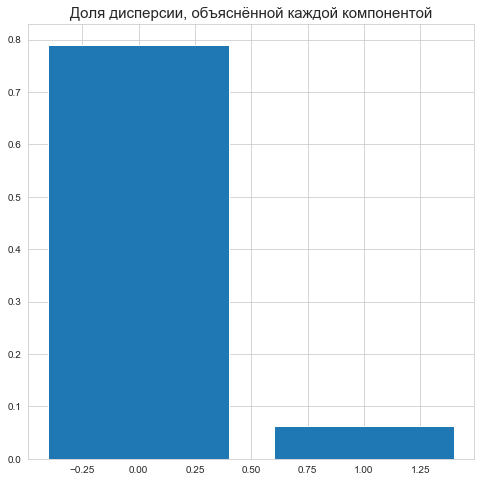

In [17]:
plt.bar(np.arange(2), pc.explained_variance_ratio_);
plt.title('Доля дисперсии, объяснённой каждой компонентой', fontsize=15);

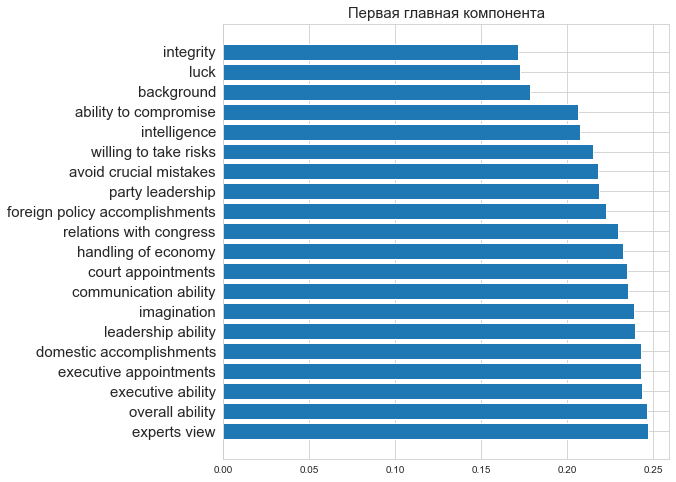

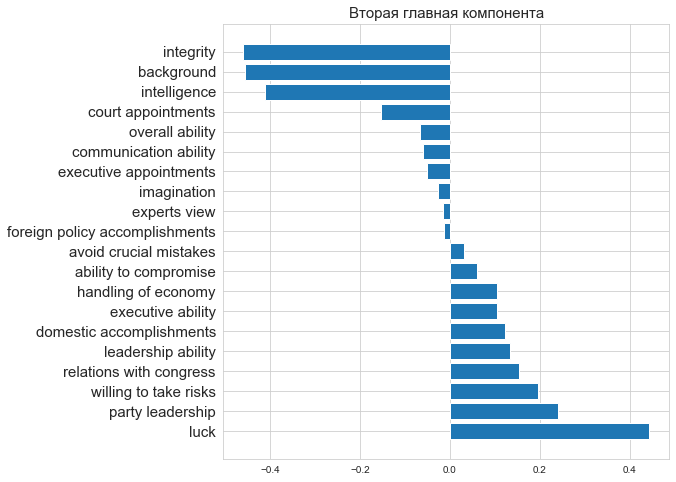

In [18]:
plt.figure(figsize=(8, 8))
plt.title('Первая главная компонента', fontsize=15)
plt.barh(
    np.array(features)[np.argsort(pc.components_[0])[::-1]], np.sort(pc.components_[0])[::-1]
);
plt.yticks(fontsize=15);

plt.figure(figsize=(8, 8))
plt.title('Вторая главная компонента', fontsize=15)
plt.barh(
    np.array(features)[np.argsort(pc.components_[1])[::-1]], np.sort(pc.components_[1])[::-1]
);
plt.yticks(fontsize=15);

В первой главной компоненте мало интересного - она содержит примерно поровну всех факторов, а вот у второй главной компоненты интересная интерпретация. Она положительно связана с такими факторами, как "удачливость" и "желание идти на риск", и отрицательно связана с факторами "образование" и "интелект". Получается, что президенты, у которых малое значение второй главной компоненты, это те, которых респонденты скорее относят к "игрокам", нежели грамотным управленцам.

comp2 = -0.46 $\cdot$ integrity - 0.455 $\cdot$ background - 0.412 $\cdot$ intelligence + $\dots$

То есть, чем больше значение intelligence, тем меньше значение второй главной компоненты (а бОльшее значение intelligent соответсвует более низкому значению в рейтинге по данному показателю).

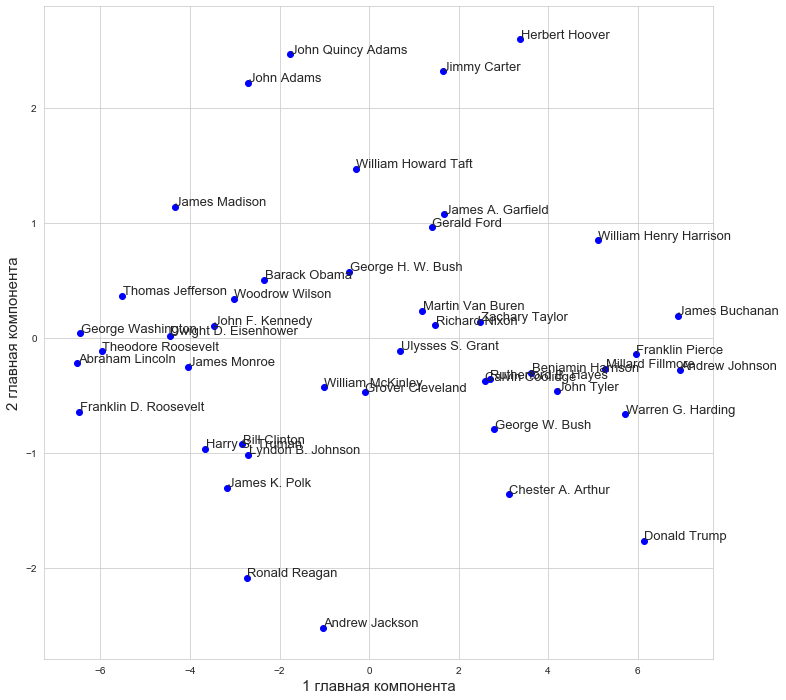

In [21]:
plt.figure(figsize=(12, 12))
for i, dat in enumerate(X_pc):
    plt.scatter(dat[0], dat[1], color='blue');
    plt.text(dat[0]+0.01, dat[1]+0.01, presidents_df.name[i], fontsize=13)
plt.xlabel('1 главная компонента', fontsize=15);
plt.ylabel('2 главная компонента', fontsize=15);

Отсортируем президентов по значению второй главной компоненты

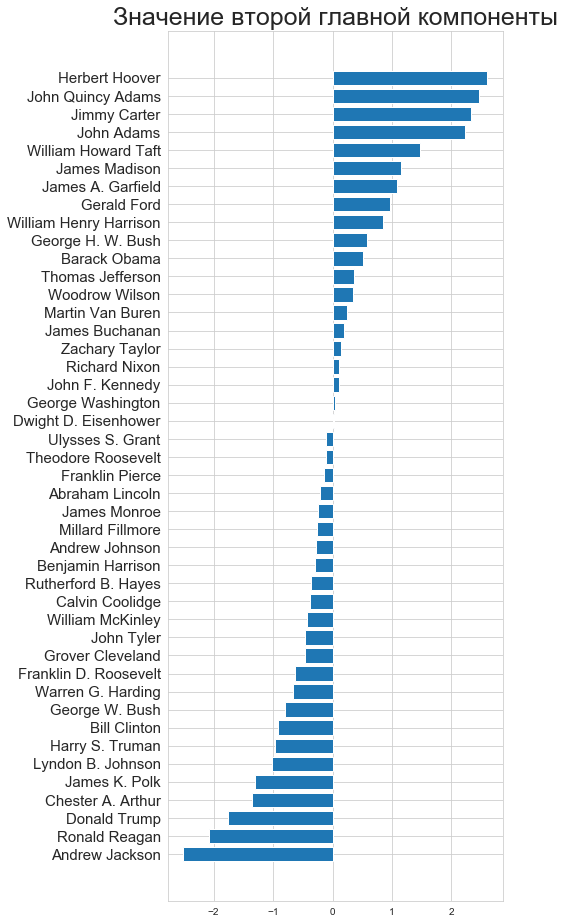

In [57]:
names = presidents_df.name.values
names = names[np.argsort(X_pc[:, 1])]
comp2_sorted = np.sort(X_pc[:, 1])

plt.figure(figsize=(6, 16))
plt.title(f'Значение второй главной компоненты', fontsize=25);
plt.barh(names, comp2_sorted)
plt.tick_params(axis='y', labelsize=15);

Сравним топ 3 президентов с самым большим значением данной компоненты с топ 3 президентами с самым маленьким значением. 

<strong>Herbert Hoover, Jimmy Carter, John Quincy Adams</strong> - это те президенты, у которых должно быть либо маленькое значение показателей (intelligence, background, integrity), либо большое значение показателей (willing to take risks, party leadership, luck) (либо и то и то). То есть это такие президенты, которых считают "интеллектуалами", но возможно им не везло.

<strong>Donald Trump, Ronald Reagan, Andrew Jackson</strong> - это, напротив, президенты либо с высоким значением (intelligence, background, integrity) (что в свою очередь интерпретируется как самый низкий рейтинг по этим критериям), либо с низким значением (willing to take risks, party leadership, luck) (то есть наоборот - эти качества связывают с ними). То есть эти презинденты выглядят в глазах народа "везунчиками" и "игроками".

In [75]:
presidents_df.set_index(['name'], inplace=True)
presidents_df.loc[
    ['Herbert Hoover', 'John Quincy Adams', 'Jimmy Carter', 
     'Donald Trump', 'Ronald Reagan', 'Andrew Jackson']
    ,
    ['integrity', 'background', 'intelligence', 'willing to take risks', 'party leadership', 'luck']
]

,integrity,background,intelligence,willing to take risks,party leadership,luck
name,,,,,,
Herbert Hoover,15,13,13,37,32,43
John Quincy Adams,6,1,5,19,29,29
Jimmy Carter,3,25,15,27,37,38
Donald Trump,44,43,44,25,43,10
Ronald Reagan,24,27,31,13,4,3
Andrew Jackson,29,37,28,4,6,4


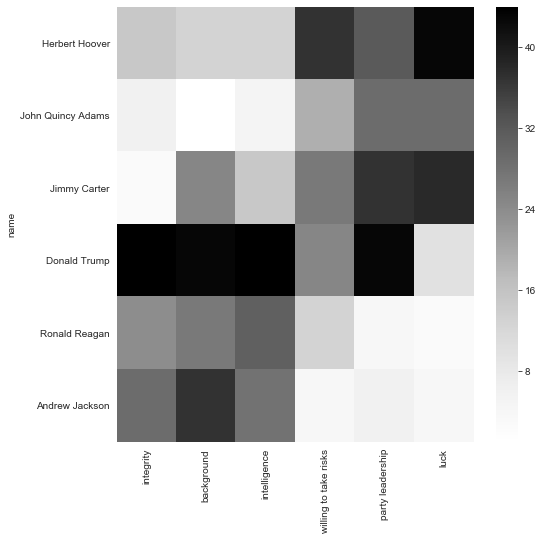

In [80]:
sns.heatmap(presidents_df.loc[
    ['Herbert Hoover', 'John Quincy Adams', 'Jimmy Carter', 
     'Donald Trump', 'Ronald Reagan', 'Andrew Jackson']
    ,
    ['integrity', 'background', 'intelligence', 'willing to take risks', 'party leadership', 'luck']
], cmap='Greys');

Ещё один пример:

https://archive.ics.uci.edu/ml/datasets/Turkiye%2BStudent%2BEvaluation

In [4]:
dat = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/turkiye-student-evaluation_R_Specific.csv')
dat.columns = [col.replace('.', '_').lower().strip() for col in dat.columns]

Сделаем из переменной difficulty бинарную переменную, из которой возьмём крайние значения сложности курса

In [5]:
def func1(x):
    if x == 1:
        return 0
    elif (2 <= x <= 4):
        return -1
    else:
        return 1

dat['binary_difficulty1'] = dat.difficulty.apply(lambda x: func1(x))
dat = dat.loc[dat.binary_difficulty1 != -1]

In [6]:
dat.head()

,instr,class,nb_repeat,attendance,difficulty,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22,q23,q24,q25,q26,q27,q28,binary_difficulty1
5,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
22,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
39,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
50,1,2,1,1,5,4,4,4,4,4,4,4,4,3,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1
56,1,2,1,1,1,1,1,1,1,1,1,1,5,1,1,1,5,5,5,5,5,5,4,5,5,5,5,5,5,5,4,5,5,0


Выберем все переменные кроме целевой (difficulty и binary_difficulty) и нормируем данные

In [7]:
X_min_max = dat.apply(lambda x: (x - x.min())/(x.max() - x.min()))[dat.columns.difference(['difficulty', 'binary_difficulty1'])]
X_st = dat.apply(lambda x: (x - x.mean())/(x.std()))[dat.columns.difference(['difficulty', 'binary_difficulty1'])]

In [8]:
pc = PCA(n_components=None).fit(X_st)
X_st_pc = pc.transform(X_st)

In [25]:
clf = LogisticRegression()
clf.fit(X_st_pc[:, 1:3], categories)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

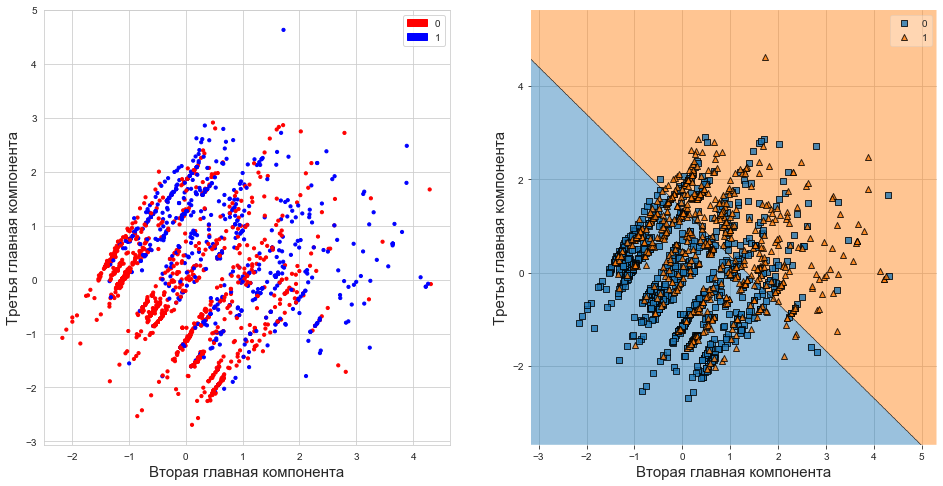

In [26]:
colors = np.array(['red', 'blue', 'yellow', 'limegreen', 'orange', 'purple', 'brown'])
categories = dat.binary_difficulty1.values
uniq_categories = np.unique(categories)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].scatter(X_st_pc[:, 1], X_st_pc[:, 2], 
            color=colors[categories], 
            s=10);
ax[0].legend(handles=[mpatches.Patch(color='{}'.format(colors[i]), label='{}'.format(uniq_categories[i])) for i in range(len(uniq_categories))])
ax[0].set_xlabel('Вторая главная компонента', fontsize=15);
ax[0].set_ylabel('Третья главная компонента', fontsize=15);

plot_decision_regions(X_st_pc[:, 1:3], categories, clf=clf, ax=ax[1]);
ax[1].set_xlabel('Вторая главная компонента', fontsize=15);
ax[1].set_ylabel('Третья главная компонента', fontsize=15);

Интерпретация полученных главных компонент

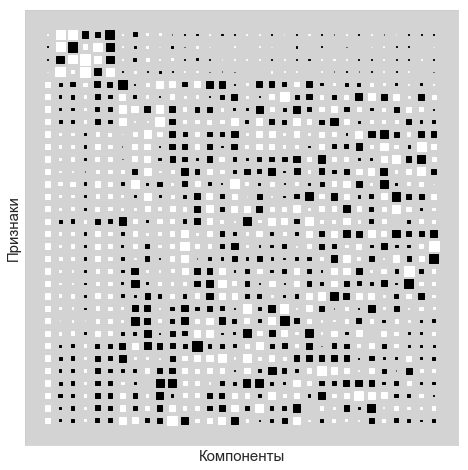

In [340]:
hinton(pc.components_)

Первая главная компонента отвечает за результаты ответов на вопросы q1 - q28. Вторая и третья главные компоненты отвечают за то, как студент посещал курс и выполнял задания.

Посмотрим на качество классификации на полном наборе данных и на наборе данных из 3 главных компонент

In [366]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [371]:
rf_full = RandomForestClassifier(n_estimators=100)
rf_full.fit(X_st.values, dat.binary_difficulty1)

k = 3
rf_pc = RandomForestClassifier(n_estimators=100)
rf_pc.fit(X_st_pc[:, :k], dat.binary_difficulty1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [372]:
print('Качество на полном наборе:', f1_score(y_true=dat.binary_difficulty1, y_pred=rf_full.predict(X_st.values)))
print("Качество на 3 главных компонентах:", f1_score(y_true=dat.binary_difficulty1, y_pred=rf_pc.predict(X_st_pc[:, :k])))

Качество на полном наборе: 0.8939157566302652
Качество на 3 главных компонентах: 0.8942457231726284


### Кластеризация

Задача кластеризация это задача разделения объектов на множества (кластеры), которые обладают следующим свойством - объекты внутри одного кластера должны быть "похожи" друг на друга, а объекты из разных кластеров должны "отличаться" друг от друга.

В неформальном определении кластера фигурируют слова <strong><i>похожи</i></strong> и <strong><i>непохожи</i></strong>. В понимании этих неформальных определений кроется ключ к построению различных алгоритмов кластеризации. Однако, так или иначе "похожесть" объектов тесно связана с расстоянием между этими объектами.

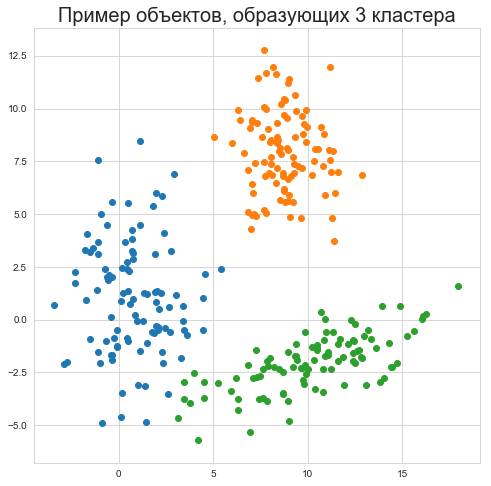

In [87]:
x1 = np.random.multivariate_normal(mean=[1, 1], cov=np.array([[3, 0], [0, 10]]), size=100)
x2 = np.random.multivariate_normal(mean=[9, 8], cov=np.array([[2, 0], [0, 3]]), size=100)
x3 = np.random.multivariate_normal(mean=[10, -2], cov=np.array([[10, 3], [3, 2]]), size=100)
X = np.r_[x1, x2, x3]

plt.scatter(x1[:, 0], x1[:, 1]);
plt.scatter(x2[:, 0], x2[:, 1]);
plt.scatter(x3[:, 0], x3[:, 1]);
plt.title('Пример объектов, образующих 3 кластера', fontsize=20);

Одним из самых известных и старых алгоритмов кластеризации является [<font color='limegreen'>K-Means</font>](https://ru.wikipedia.org/wiki/Метод_k-средних) (Методы k средних). Рассмотрим пример его работы.

<b>Алгоритм KMeans</b>:

1) Случайно инициализируем центры k кластеров ($c_{i}, \ i = 1, \dots, k$)

2) Относим к классу i все объекты, которые ближе всего к i-ому центру ($c_{i}$)

3) Пересчитываем центры кластеров как $c_{i} = \frac{1}{|A_{i}|} \sum\limits_{x \in A_{i}}x \ $ (Где: $A_{i}$ - множество всех объектов, которые принадлежат к i-ому кластеру, $|A_{i}|$ - мощность этого множества) (По факту, $c_{i}$ - среднее значение координат точек i-ого кластера)

Шаги 2-3 повторяем до выполнения условия сходимости (например, когда центры кластеров перестанут сильно меняться).

Посмотрим на итерации kmeans на примере данных выше

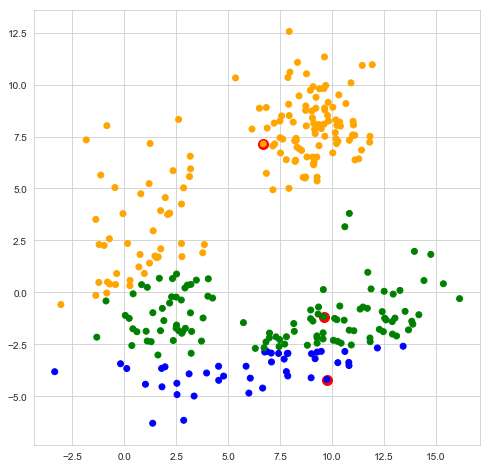

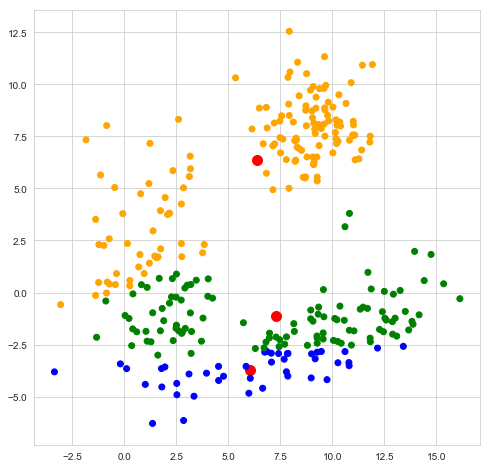

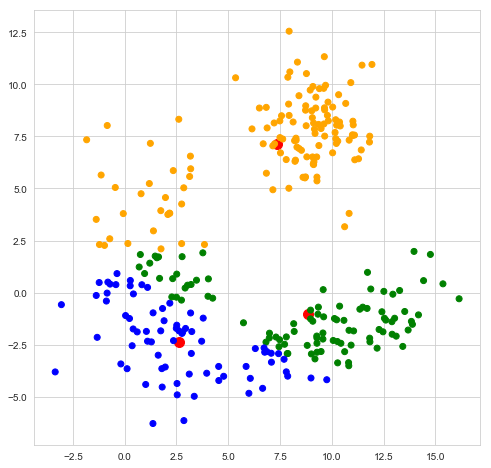

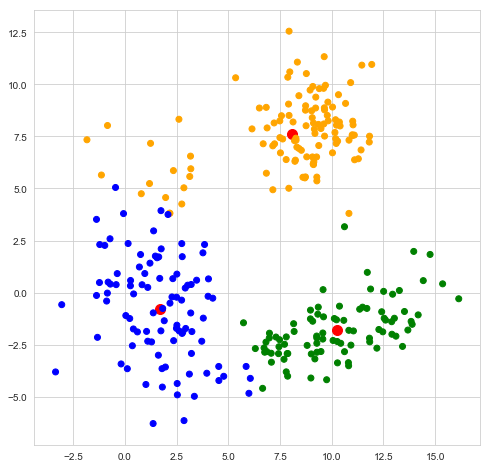

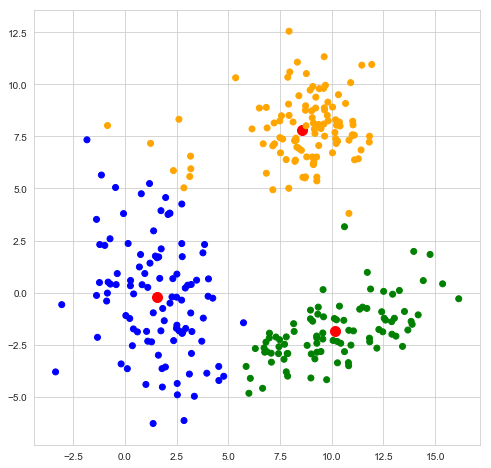

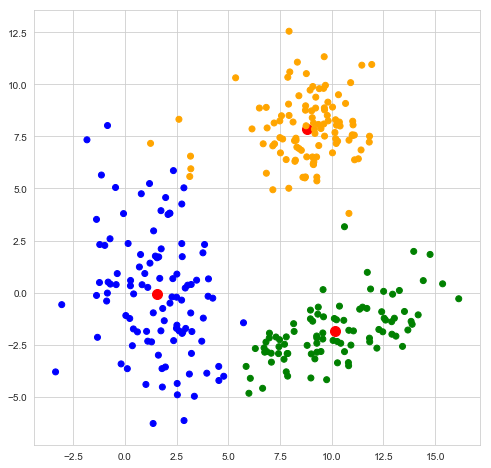

In [8]:
cluster_centers = X[np.random.choice(np.arange(X.shape[0]), size=3)]
previous_centers = cluster_centers
centers_distance_change = []
cluster_labels = np.argsort(scipy.spatial.distance.cdist(cluster_centers, X), axis=0)[0]
plt.figure(figsize=(8, 8))
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', s=100)
plt.scatter(X[:, 0], X[:, 1], c=np.array(['green', 'blue', 'orange'])[cluster_labels]);

for i in range(5):
    # отнесение объектов по кластерам
    cluster_labels = np.argsort(scipy.spatial.distance.cdist(cluster_centers, X), axis=0)[0]
    # пересчёт центров кластеров
    cluster_centers = []
    for j in range(3):
        cluster_centers.append(X[cluster_labels == j].mean(axis=0))
    cluster_centers = np.array(cluster_centers)
    centers_distance_change.append(((cluster_centers - previous_centers)**2).sum(axis=1).mean())
    previous_centers = cluster_centers
    plt.figure(figsize=(8, 8))
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', s=100)
    plt.scatter(X[:, 0], X[:, 1], c=np.array(['green', 'blue', 'orange'])[cluster_labels]);


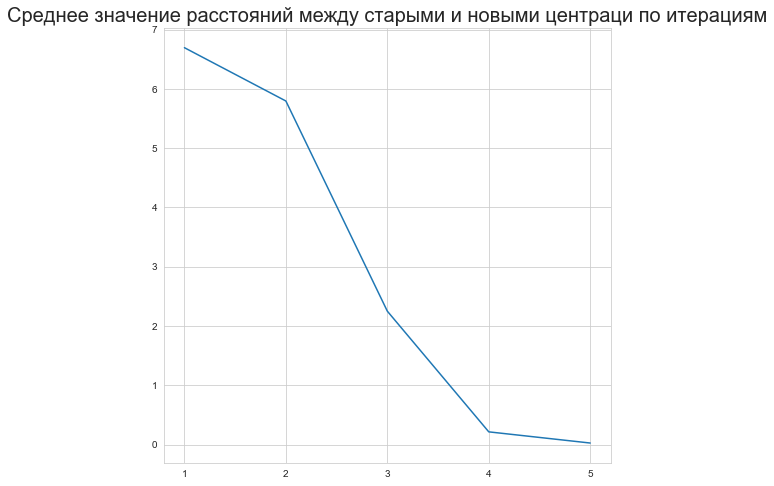

In [9]:
plt.plot(range(5), centers_distance_change);
plt.xticks(range(5), range(1, 5+1))
plt.title('Среднее значение расстояний между старыми и новыми центраци по итерациям', fontsize=20);

С использованием sklearn

In [10]:
from sklearn.cluster import KMeans

In [11]:
clus = KMeans(n_clusters=3)
clus.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

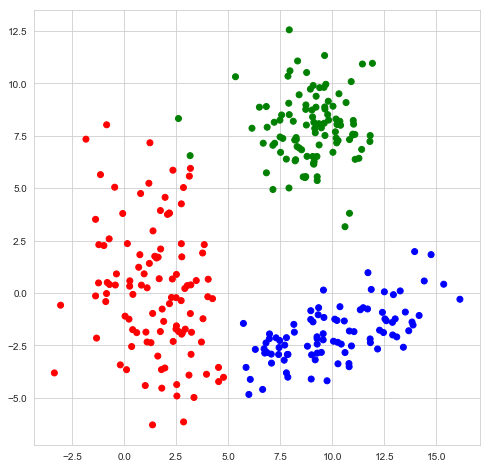

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=np.array(['red', 'green', 'blue'])[clus.labels_]);

У алгоритма K-Means есть существенный недостаток - число кластеров n_clusters нужно подавать как гиперпараметр. Без априорного знания о числе кластеров сделать это сложно. Рассмотрим алгоритм, который автоматически определяет число кластеров - [DBSCAN](https://ru.wikipedia.org/wiki/DBSCAN).

In [13]:
from sklearn.cluster import DBSCAN

In [14]:
clus = DBSCAN(eps=1.1)
clus.fit(X)

DBSCAN(algorithm='auto', eps=1.1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

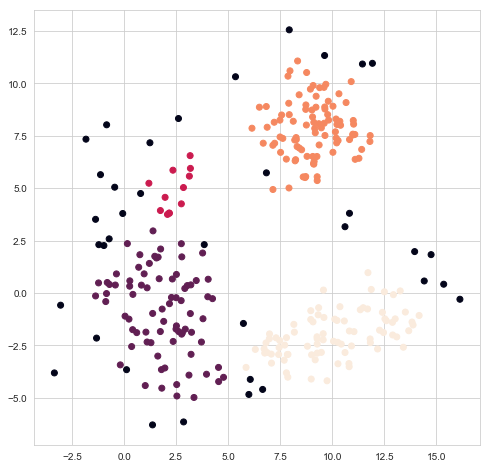

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=clus.labels_);

Иерархическая кластеризация позволяет исследователю самому выбрать порог объединения кластеров, визуализируя всевозможные кластеры по в зависимости от расстояния между объектами

In [86]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

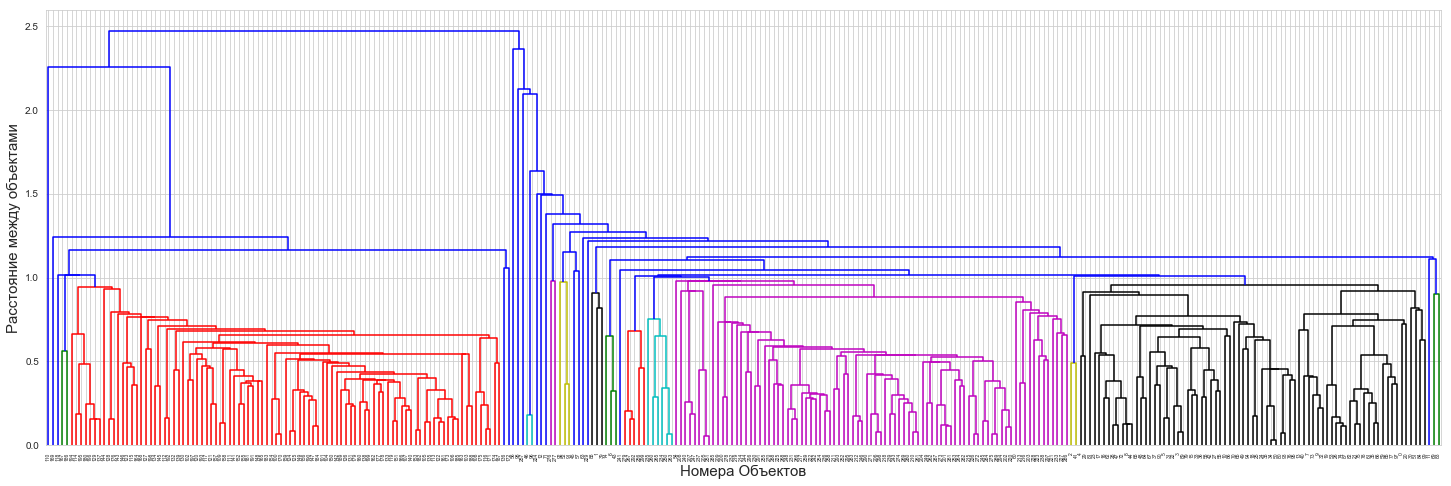

In [93]:
link = linkage(pdist(X))
plt.figure(figsize=(25, 8))
_ = dendrogram(link, color_threshold=1);
plt.ylabel('Расстояние между объектами', fontsize=15);
plt.xlabel('Номера Объектов', fontsize=15);

### Сегментация покупателей

In [104]:
aisles = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [105]:
departments = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [106]:
orders = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [107]:
prior = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/order_products__prior.csv')               
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [108]:
prior = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/order_products__prior.csv')               
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [109]:
products = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/products.csv')               
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [110]:
%%time
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
dat = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
# рассмотрим только юзеров с историей больше 1500 покупок
needed_users = dat.user_id.value_counts().keys()[dat.user_id.value_counts() >= 1300].values
dat = dat.loc[dat.user_id.isin(needed_users)]

Wall time: 2min 13s


Составим матрицу (покупатель х товар) и произведём tf-idf трансформацию этой матрицы

In [111]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer
user_product = pd.crosstab(dat.user_id, dat.aisle)
tfidf = TfidfTransformer()
tfidf.fit(user_product.values)
user_product = pd.DataFrame(tfidf.transform(user_product.values).toarray(), columns=user_product.columns)

Wall time: 1.36 s


In [112]:
user_product.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,...,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0.0,0.019403,0.0,0.0,0.018645,0.000000,0.019394,0.000000,0.000000,0.000000,0.000000,0.002410,0.000000,0.000000,0.000000,0.000000,0.070877,0.023460,0.000000,0.000000,0.013817,0.104695,0.000000,0.0,0.059333,...,0.00000,0.002666,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.007997,0.000000,0.021228,0.000000,0.004957,0.000000,0.037552,0.000000,0.393114,0.037596,0.0,0.000000,0.000000,0.048926,0.000000,0.221710
1,0.0,0.008958,0.0,0.0,0.003443,0.010036,0.062681,0.008657,0.010393,0.000000,0.025068,0.008902,0.004037,0.000000,0.000000,0.000000,0.004909,0.000000,0.063703,0.029218,0.040829,0.049610,0.015182,0.0,0.046452,...,0.00000,0.062769,0.0,0.007889,0.000000,0.0,0.0,0.000000,0.029749,0.008615,0.016814,0.003267,0.000000,0.009155,0.000000,0.003251,0.016763,0.000000,0.002671,0.0,0.000000,0.021394,0.001255,0.000000,0.078340
2,0.0,0.038391,0.0,0.0,0.215980,0.000000,0.067155,0.017707,0.000000,0.023631,0.008545,0.245799,0.047702,0.043338,0.000000,0.000000,0.089244,0.062362,0.007239,0.037497,0.034796,0.159578,0.000000,0.0,0.042227,...,0.53436,0.110764,0.0,0.000000,0.000000,0.0,0.0,0.009091,0.000000,0.073842,0.033627,0.004455,0.025897,0.024967,0.013108,0.008866,0.000000,0.005380,0.065546,0.0,0.006757,0.000000,0.000000,0.297305,0.296255
3,0.0,0.053931,0.0,0.0,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.250090,0.041581,0.006378,0.048925,0.000000,0.022984,0.010144,0.126771,0.004829,0.003585,0.110787,0.000000,0.0,0.063578,...,0.00000,0.000000,0.0,0.026596,0.040945,0.0,0.0,0.000000,0.000000,0.034578,0.069284,0.000000,0.000000,0.022505,0.000000,0.027399,0.014491,0.000000,0.127546,0.0,0.006960,0.000000,0.014103,0.000000,0.275849
4,0.0,0.031697,0.0,0.0,0.013121,0.000000,0.059711,0.000000,0.006600,0.000000,0.000000,0.171719,0.002563,0.000000,0.000000,0.021368,0.015587,0.016051,0.091027,0.000000,0.131267,0.067860,0.012396,0.0,0.056731,...,0.00000,0.009380,0.0,0.003006,0.000000,0.0,0.0,0.003175,0.000000,0.091450,0.083291,0.037346,0.000000,0.100292,0.000000,0.082582,0.017197,0.000000,0.035616,0.0,0.000000,0.006793,0.000000,0.000000,0.009950


Визуализируем получившуюся матрицу

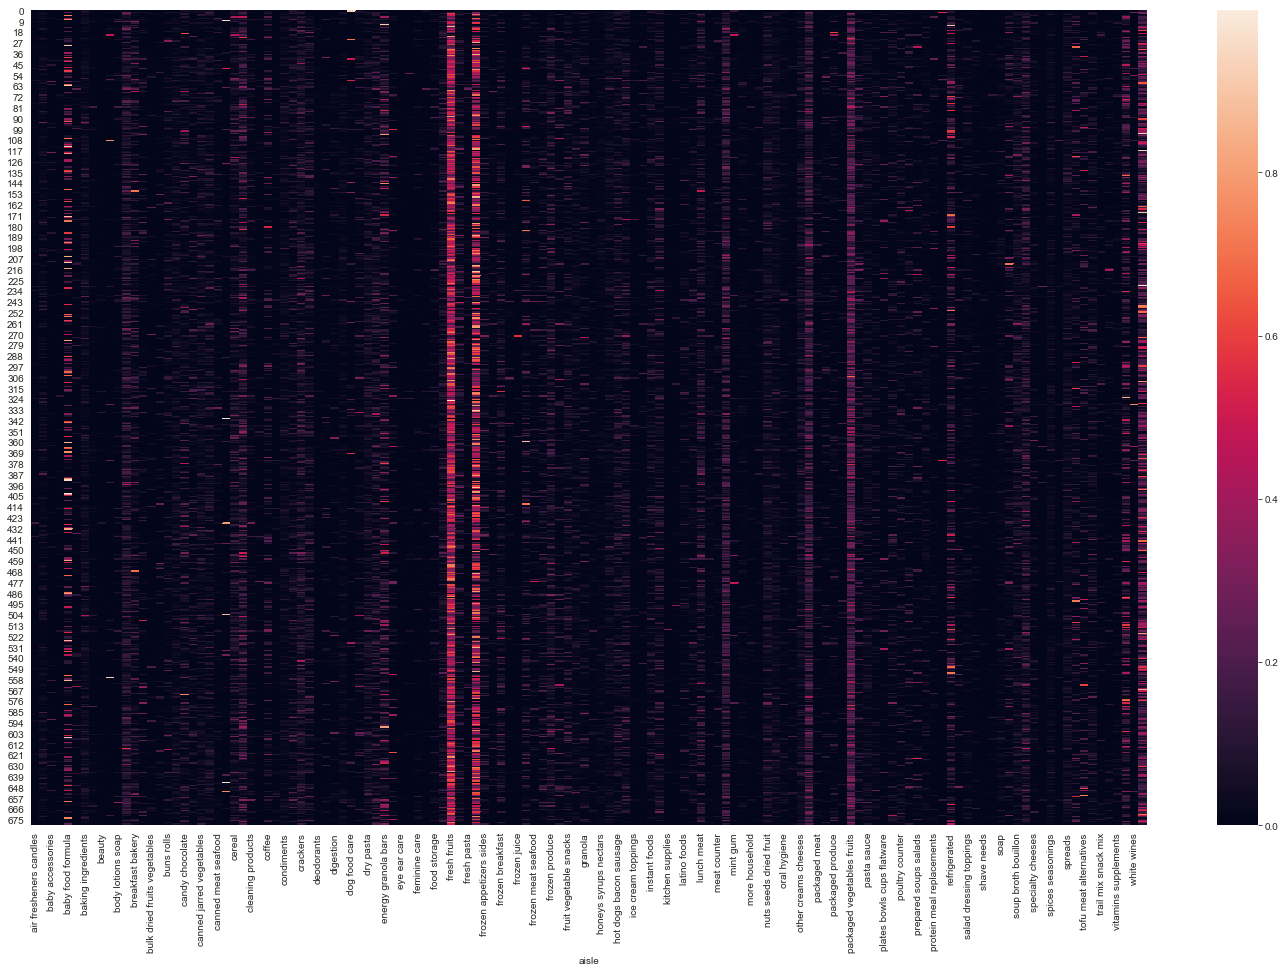

In [13]:
plt.figure(figsize=(25, 15))
sns.heatmap(user_product);

Найдём главные компоненты

In [14]:
%%time
from sklearn.decomposition import PCA
pc = PCA(n_components=None).fit(user_product)
X_pc = pc.transform(user_product)

Wall time: 1.04 s


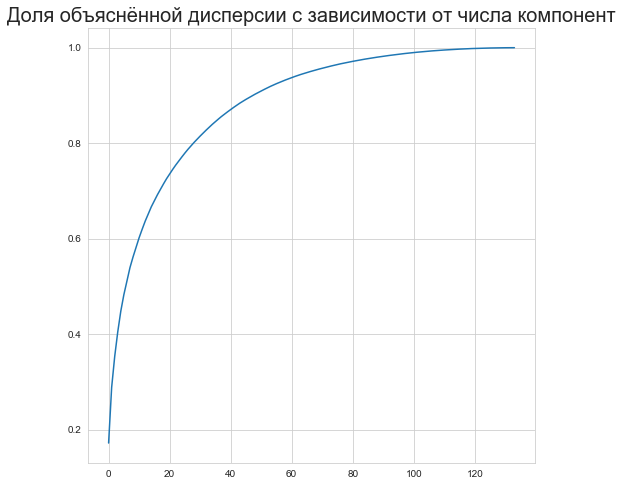

In [15]:
plt.plot(pc.explained_variance_ratio_.cumsum());
plt.title('Доля объяснённой дисперсии с зависимости от числа компонент', fontsize=20);

Визуализация главных компонент

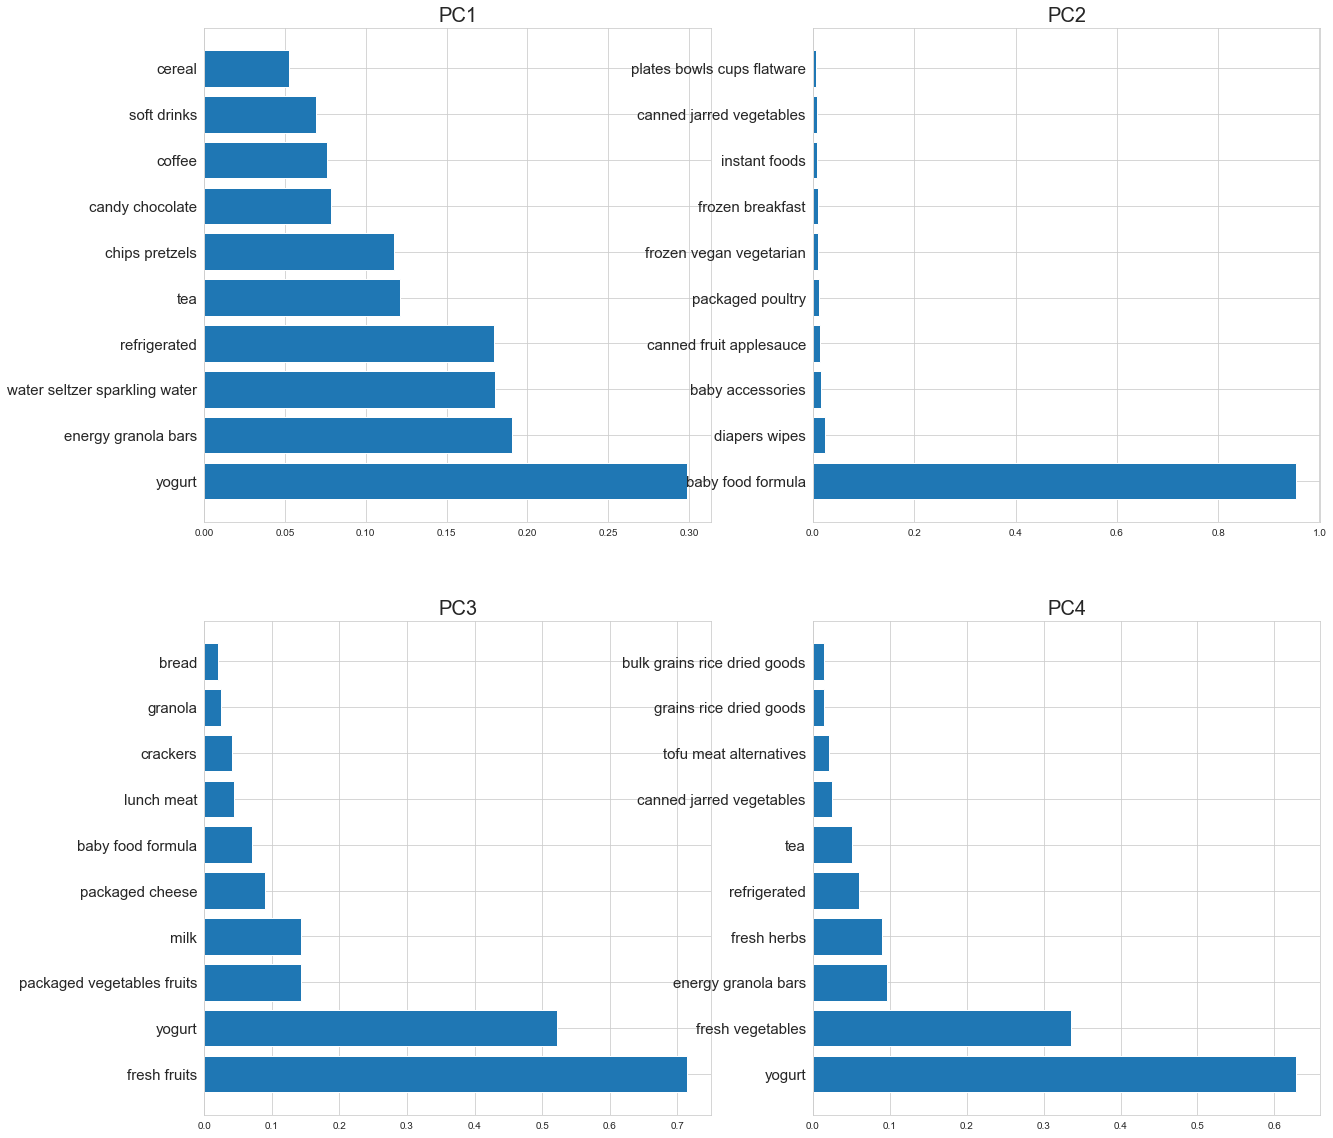

In [16]:
import itertools
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20));
for k, (i, j) in enumerate(itertools.product([0, 1], [0, 1])):
    ax[i, j].barh(user_product.columns.values[np.argsort(pc.components_[k])[::-1]][:10], np.sort(pc.components_[k])[::-1][:10])
    ax[i, j].set_title('PC{}'.format(k+1), fontsize=20);
    plt.sca(ax[i, j])
    plt.yticks(fontsize=15);

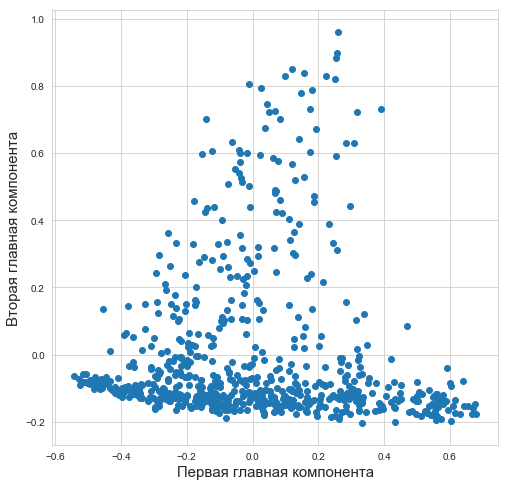

In [20]:
plt.scatter(X_pc[:, 0], X_pc[:, 1]);
plt.xlabel('Первая главная компонента', fontsize=15);
plt.ylabel('Вторая главная компонента', fontsize=15);

Уже по смыслу первых двух компонент, можно отедить покупателей, имеющих детей

In [21]:
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.manifold import TSNE

Составим кластера по 5 первым главным компонентам

In [22]:
%%time
clus = MiniBatchKMeans(n_clusters=5, max_iter=40)
clus.fit(X_pc[:, :5])

Wall time: 27 ms


Посмотрим на топ 10 продуктов получившихся кластеров

In [25]:
for clust in np.unique(clus.labels_)[0:]:
    print('Cluster {}:'.format(clust + 1))
    print(', '.join(user_product.loc[clus.labels_ == clust].mean(axis=0).sort_values(ascending=False)[:10].keys().values))
    print()

Cluster 1:
yogurt, fresh fruits, energy granola bars, refrigerated, water seltzer sparkling water, tea, chips pretzels, milk, packaged vegetables fruits, packaged cheese

Cluster 2:
fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, packaged cheese, milk, chips pretzels, bread, crackers, baby food formula

Cluster 3:
baby food formula, fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, packaged cheese, milk, soy lactosefree, water seltzer sparkling water, chips pretzels

Cluster 4:
fresh vegetables, fresh fruits, packaged vegetables fruits, yogurt, packaged cheese, fresh herbs, soy lactosefree, milk, bread, frozen produce

Cluster 5:
fresh fruits, fresh vegetables, chips pretzels, packaged vegetables fruits, packaged cheese, water seltzer sparkling water, yogurt, refrigerated, bread, milk



Кластеры не отличаются по наимениваниям продуктов - возможно они отличаются по количеству потребляемых продуктов

In [26]:
l = list(set(['fresh fruits', 'fresh vegetables', 'packaged vegetables fruits', 'yogurt', 'packaged cheese', 'chips pretzels', 'milk', 'bread', 'water seltzer sparkling water', 'soy lactosefree', 
'yogurt', 'fresh fruits', 'energy granola bars', 'refrigerated', 'tea', 'chips pretzels', 'milk', 'candy chocolate', 'packaged vegetables fruits', 
'fresh fruits', 'baby food formula', 'packaged cheese', 'packaged cheese', 'oils vinegars', 'frozen produce', 'canned meals beans']))

In [27]:
cluster_df = pd.DataFrame(columns=l)
for clust in np.unique(clus.labels_):
    current_cluster_df = pd.DataFrame(user_product.loc[clus.labels_ == clust, l].mean(axis=0)).T
    cluster_df = pd.concat([cluster_df, current_cluster_df/current_cluster_df.sum().sum()])
cluster_df.index = range(1, cluster_df.shape[0]+1)
cluster_df

aisle,refrigerated,packaged vegetables fruits,energy granola bars,water seltzer sparkling water,soy lactosefree,packaged cheese,baby food formula,canned meals beans,tea,frozen produce,milk,yogurt,chips pretzels,candy chocolate,fresh vegetables,fresh fruits,bread,oils vinegars
1,0.085572,0.048613,0.092114,0.084680,0.033319,0.041096,0.005399,0.003490,0.056471,0.008730,0.049863,0.205179,0.052909,0.038611,0.026239,0.142075,0.022605,0.003036
2,0.031024,0.102196,0.026276,0.031957,0.030571,0.062618,0.032805,0.016723,0.009983,0.029114,0.052750,0.080617,0.039114,0.014422,0.157331,0.232390,0.038677,0.011431
3,0.026604,0.075888,0.024310,0.027218,0.029788,0.048995,0.266799,0.013665,0.007964,0.026332,0.041473,0.072550,0.027021,0.012150,0.116919,0.146500,0.026596,0.009226
4,0.021410,0.097419,0.022824,0.028350,0.036319,0.045782,0.021407,0.026683,0.011285,0.029724,0.034952,0.048975,0.027203,0.010982,0.297205,0.187510,0.030452,0.021519
5,0.059258,0.078688,0.050312,0.074398,0.048911,0.074735,0.011346,0.013327,0.033629,0.027818,0.054712,0.065116,0.082930,0.027767,0.083341,0.144731,0.056868,0.012112


Визуализируем получившиеся кластеры

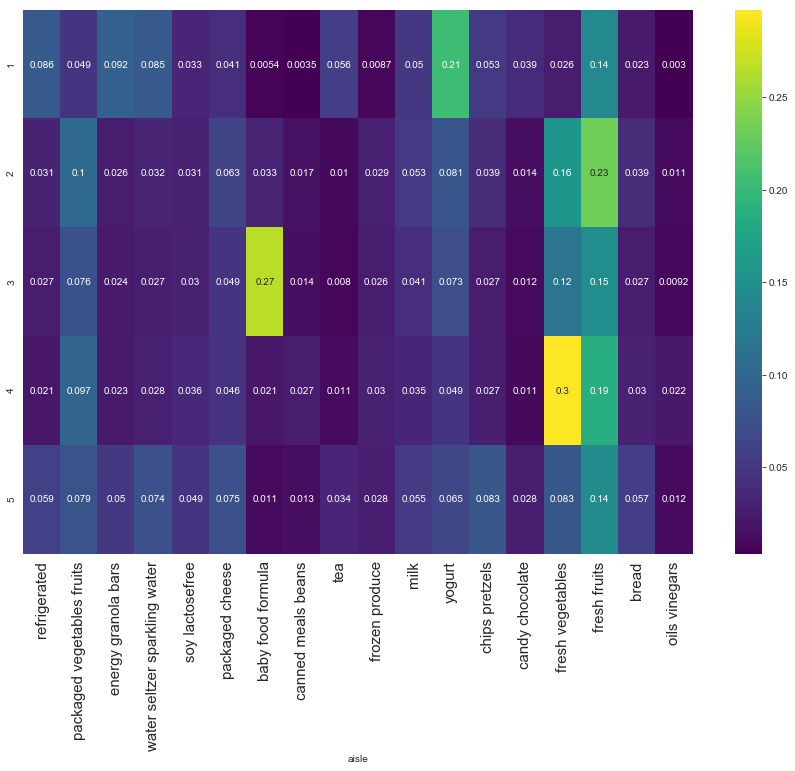

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(cluster_df, cmap='viridis', annot=True);
plt.xticks(fontsize=15);

Кроме того, увидим, что эти кластеры так же отличаются и по потреблении товаров, которые не являются товарами первой необходимости

In [29]:
for clust in np.unique(clus.labels_)[0:]:
    print('Cluster {}:'.format(clust + 1))
    print(', '.join(user_product.loc[clus.labels_ == clust].mean(axis=0).sort_values(ascending=False)[13:23].keys().values))
    print()

Cluster 1:
fresh dips tapenades, cream, fresh vegetables, lunch meat, cereal, bread, crackers, granola, fruit vegetable snacks, soft drinks

Cluster 2:
soy lactosefree, frozen produce, eggs, energy granola bars, juice nectars, ice cream ice, hot dogs bacon sausage, frozen breakfast, cereal, dry pasta

Cluster 3:
frozen produce, energy granola bars, cereal, eggs, frozen meals, lunch meat, frozen breakfast, fresh dips tapenades, nuts seeds dried fruit, hot dogs bacon sausage

Cluster 4:
tofu meat alternatives, canned jarred vegetables, energy granola bars, baking ingredients, soup broth bouillon, nuts seeds dried fruit, dry pasta, oils vinegars, refrigerated, baby food formula

Cluster 5:
lunch meat, frozen meals, soft drinks, crackers, breakfast bakery, ice cream ice, juice nectars, tea, coffee, paper goods

